<a href="https://colab.research.google.com/github/shakyarujan/Deep-Learning-with-PyTorch/blob/master/Classify_Clothing_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('Fashion-MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('Fashion-MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


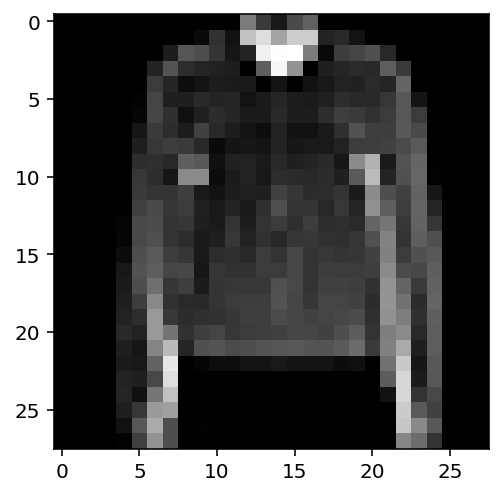

In [0]:
images, labels = next(iter(trainloader))
print(type(images))
print(images.shape)
print(labels.shape)
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)

    # Define the Dropout with o.2 probabilities to drop out
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = x.view(x.shape[0],-1)

    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    
    x = F.log_softmax(self.fc4(x), dim=1)

    return x

In [0]:
model = Classifier()
criterior = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [0]:
ephos = 30
steps=0
train_losses, test_losses = [], []

for e in range(ephos):
  running_loss = 0
  for images, labels in trainloader:
    logps = model(images)
    loss = criterior(logps, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0

    with torch.no_grad():
      model.eval() # Set model to evaluation model
      for images,labels in testloader:
        log_ps = model(images)
        test_loss += criterior(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    model.train() # After dropout retrain the model

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

print('TrainingLoss: {:.3F}..'.format(running_loss/len(trainloader))) 
print('TestLoss: {:.3F}..'.format(test_loss/len(testloader))) 
print('Accuracy: {:.3F}..'.format(accuracy/len(testloader))) 


TrainingLoss: 0.126..
TestLoss: 0.111..
Accuracy: 0.960..


In [0]:
# Defining the class view_classify that shows the classification of the train model which detect the text images
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

Accuracy : tensor([[84.2647]], grad_fn=<MulBackward0>)%


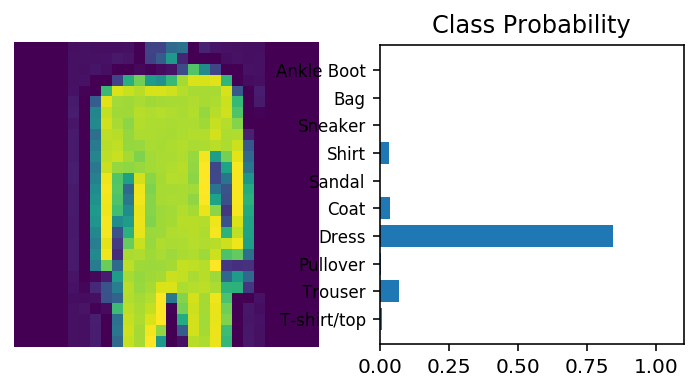

In [0]:
images, labels = next(iter(trainloader))
img = images[1]

ps = torch.exp(model(img))
view_classify(img, ps, version="Fashion")

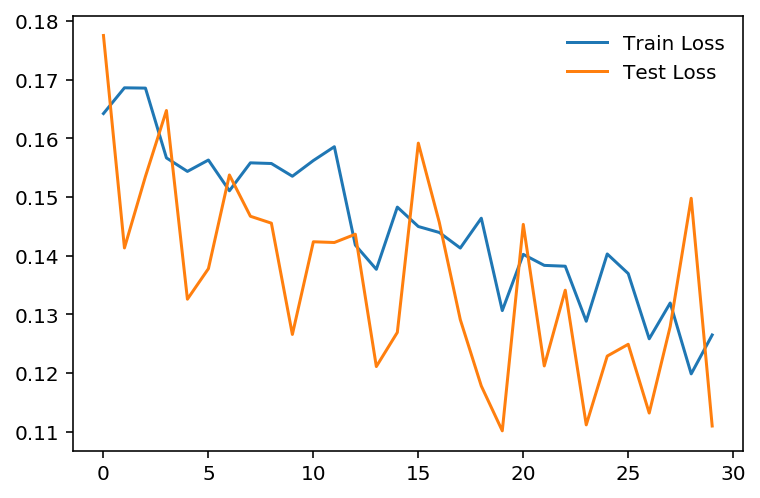

In [0]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend(frameon=False)